In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
seed = 16987856

In [5]:
# reading csv 
rmpQual = pd.read_csv("rmpCapstoneQual.csv", header=None)
rmpQuant = pd.read_csv("rmpCapstoneNum.csv", header=None)

# naming columns
rmpQuant.columns = ["avg_rating", "avg_diff", "num_ratings", "pepper", "proportion_retake", "num_online_ratings", "male", "female"]
rmpQual.columns = ["major", "university", "state"]

## Feature Engineering 

In [6]:
# note that on average, a professor has around 5 ratings
print(rmpQuant["num_ratings"].mean())

5.374721444488887


In [7]:
# first attempt -- weighting by multiplying num_ratings times avg_rating
weighted_rating = rmpQuant["avg_rating"] * rmpQuant["num_ratings"]
total_ratings = rmpQuant["num_ratings"].sum()

print(f"Mean of un-adjusted weighted ratings: {weighted_rating.mean()}")
print(f"Maximum of un-adjusted weighted ratings: {weighted_rating.max()}")

Mean of un-adjusted weighted ratings: 20.8095680246843
Maximum of un-adjusted weighted ratings: 1847.1000000000001


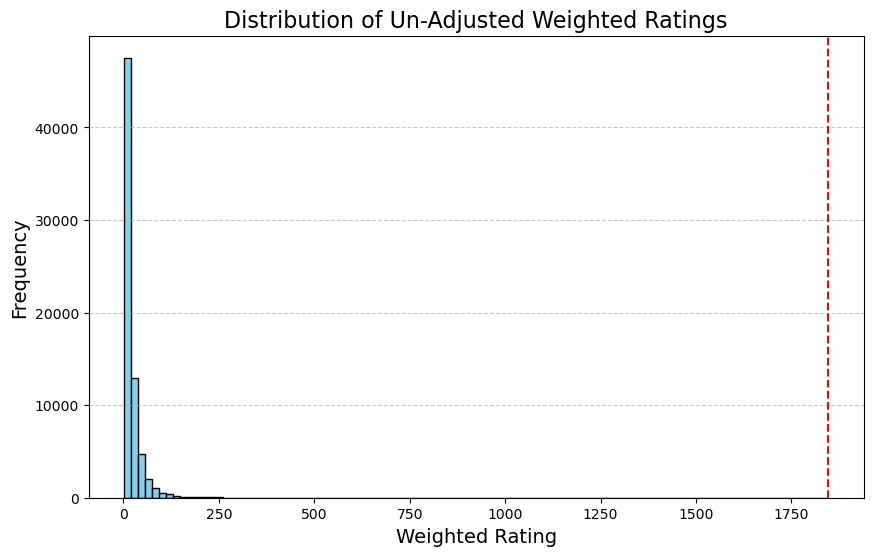

In [8]:
# these values seem extremely high -- plotting its distribution

outlier_value = weighted_rating.max()

plt.figure(figsize=(10, 6))
plt.hist(weighted_rating, bins=100, color="skyblue", edgecolor="black")

plt.title("Distribution of Un-Adjusted Weighted Ratings", fontsize=16)
plt.xlabel("Weighted Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(outlier_value, color="red", linestyle="--", label="Outlier")

plt.show()

Mean of log-adjusted weighted ratings: 5.835680435862839
Maximum of log-adjusted weighted ratings: 28.08884927370029


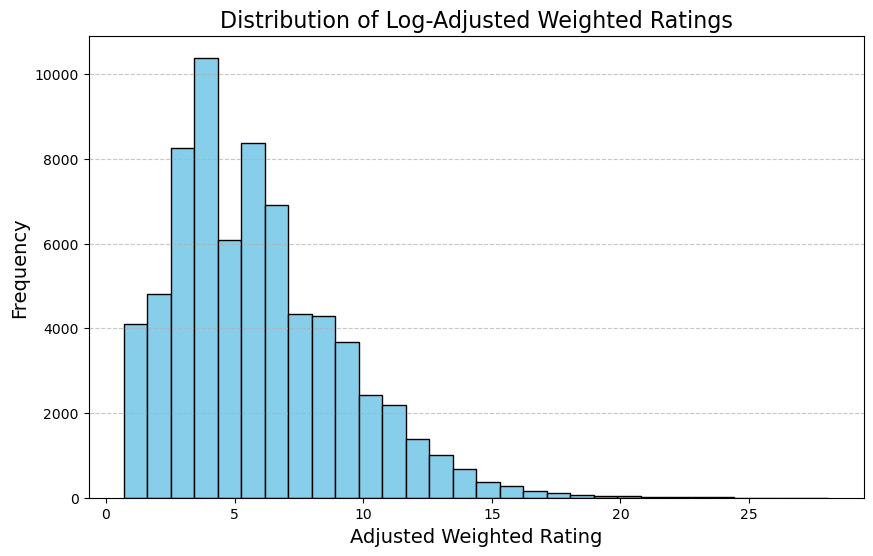

In [9]:
# attempting log weighting to reduce the decreasing exponential effect

adjusted_weight = np.log1p(rmpQuant["num_ratings"])   
log_rating = rmpQuant["avg_rating"] * adjusted_weight

print(f"Mean of log-adjusted weighted ratings: {log_rating.mean()}")
print(f"Maximum of log-adjusted weighted ratings: {log_rating.max()}")

plt.figure(figsize=(10, 6))
plt.hist(log_rating, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Log-Adjusted Weighted Ratings", fontsize=16)
plt.xlabel("Adjusted Weighted Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [10]:
# satisfied with distirbution, adding log rating as a column to my dataframe 
rmpQuant["log_rating"] = log_rating

In [11]:
# feature engineering: adding regional column and stem column

majors = rmpQual["major"].dropna()

rmpQual["stem"] = majors.map(
   lambda x: 1 if any(stem in x.upper() for stem in 
       ["MATH", "MATHEMATICS", "CALCULUS",
        "PHYSICS", "TECHNOLOGY", "MEDICAL",
        "CHEM", "CHEMISTRY", "DATA",
        "BIO", "BIOLOGY", "BIOLOGICAL",
        "COMP", "COMPUTER", "COMPUTING",
        "ENGINE", "ENGINEERING"])
   else 0 if any(hum in x.upper() for hum in 
       ["HIST", "HISTORY", "HISTORICAL", "CULTURE",
        "ENG", "ENGLISH", "LITERATURE", "EDUCATION",
        "PHILOSOPHY", "PSYCHOLOGY", "HUMANITIES",
        "ART", "ARTS", "VISUAL", "LANGUAGE",
        "CLASSICS", "ANCIENT", "DRAMA", "FILM"])
   else np.nan
)

states_to_regions = {
   "ME": "North", "NH": "North", "VT": "North", "MA": "North", "RI": "North", 
   "CT": "North", "NY": "East", "NJ": "East", "PA": "East",
   
   "MD": "East", "DE": "East", "VA": "South", "WV": "South", "NC": "South", 
   "SC": "South", "GA": "South", "FL": "South", "KY": "South", "TN": "South", 
   "AL": "South", "MS": "South", "AR": "South", "LA": "South", "TX": "South",
   
   "OH": "Midwest", "IN": "Midwest", "IL": "Midwest", "MI": "Midwest", "WI": "Midwest",
   "MN": "Midwest", "IA": "Midwest", "MO": "Midwest", "ND": "Midwest", "SD": "Midwest",
   "NE": "Midwest", "KS": "Midwest",
   
   "MT": "West", "ID": "West", "WY": "West", "CO": "West", "NM": "West", 
   "AZ": "West", "UT": "West", "NV": "West", "CA": "West", "OR": "West", 
   "WA": "West", "AK": "West", "HI": "West"
}

rmpQual["region"] = rmpQual["state"].map(states_to_regions)

## Question 1

In [12]:
# shouldn't have to drop na because only looking where men and women are equal to 1
men = rmpQuant["log_rating"][rmpQuant["male"] == 1]
women = rmpQuant["log_rating"][rmpQuant["female"] == 1]

num_men = men.shape[0]
num_women = women.shape[0]

print(f"Number of ratings for men: {num_men}")
print(f"Number of ratings for women: {num_women}")

Number of ratings for men: 29376
Number of ratings for women: 27139


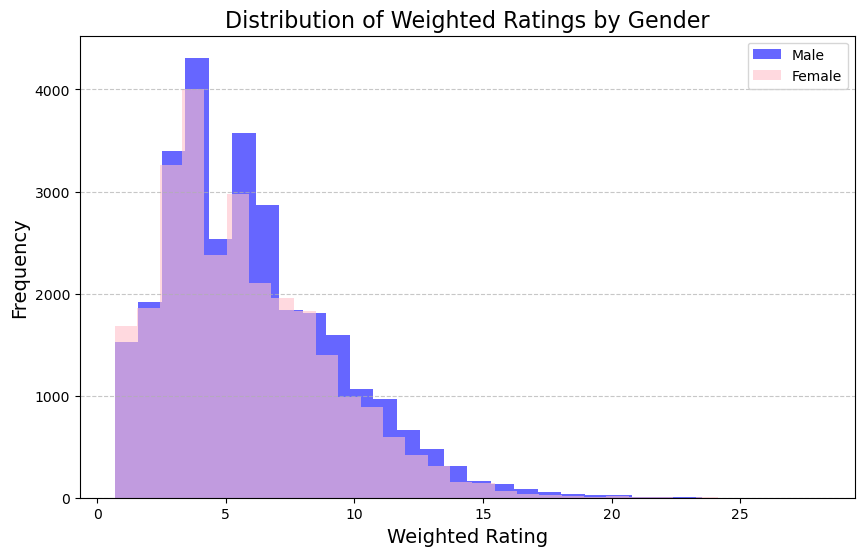

In [13]:
# want to visualize distributions before picking significance test 

plt.figure(figsize=(10, 6))

plt.hist(men, bins=30, alpha=0.6, color="blue", label="Male")
plt.hist(women, bins=30, alpha=0.6, color="pink", label="Female")

plt.title("Distribution of Weighted Ratings by Gender", fontsize=16)
plt.xlabel("Weighted Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [14]:
# not quite normal, will opt for mann-whitney u test
statistic, p_value = mannwhitneyu(men, women, 
                                 alternative="greater")  
print(f"Mann-Whitney U statistic: {statistic}")
print(f"Mann-Whitney p-value: {round(p_value, 6)}")

Mann-Whitney U statistic: 416869117.5
Mann-Whitney p-value: 0.0


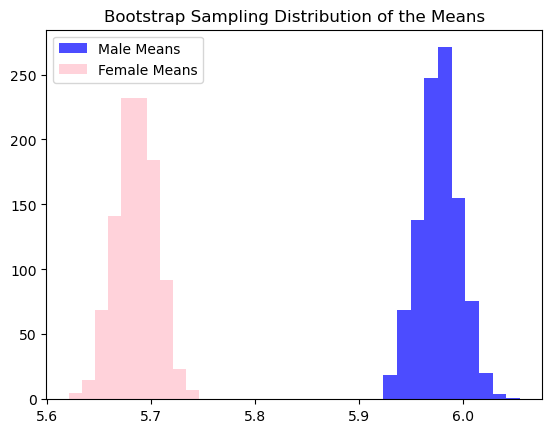

In [15]:
# this feels a bit suspicious, want to plot bootstrapped means and find cohen's d to validate

# sampling in place
male_means = [men.sample(frac=1, replace=True).mean() for _ in range(1000)]
female_means = [women.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.hist(male_means, alpha=0.7, label="Male Means", color="blue")
plt.hist(female_means, alpha=0.7, label="Female Means", color="pink")
plt.legend()
plt.title("Bootstrap Sampling Distribution of the Means")
plt.show()

In [16]:
# effect size

mean_diff = men.mean() - women.mean()
pooled_std = np.sqrt((np.std(men)**2 + np.std(women)**2) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.08806975082875688


## Question 2

In [17]:
# handling nulls at the test level
ratingExp = rmpQuant[["num_ratings","avg_rating"]].dropna()

In [18]:
# first need to split into 2 groups - "low experience" and "high experience"
# will look at bottom 25% of experience as "low" and top 25% of experience as "high"

q1 = ratingExp["num_ratings"].quantile(0.25)
q4 = ratingExp["num_ratings"].quantile(0.75)

print(f"First quartile: {q1:.0f} ratings")
print(f"Fourth quartile: {q4:.0f} ratings")

First quartile: 1 ratings
Fourth quartile: 6 ratings


In [19]:
# create groups 

low_exp = rmpQuant[rmpQuant["num_ratings"] <= q1]["avg_rating"]
high_exp = rmpQuant[rmpQuant["num_ratings"] >= q4]["avg_rating"]

low_count = low_exp.shape[0]
high_count = high_exp.shape[0]

# chacking shape
print(f"High-experience ratings: {high_count}")
print(f"Low-experience ratings: {low_count}")

High-experience ratings: 20577
Low-experience ratings: 17633


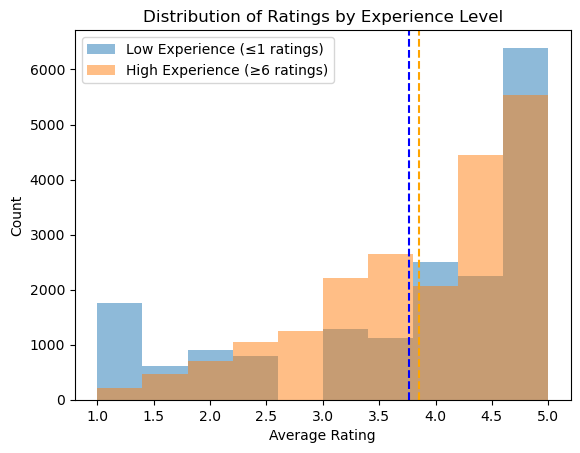

Mean rating (low experience): 3.765
Mean rating (high experience): 3.851


In [20]:
# visualzing groups to pick most suitable significance test

plt.hist(low_exp, bins=10, alpha=0.5, label=f"Low Experience (≤{q1:.0f} ratings)")
plt.hist(high_exp, bins=10, alpha=0.5, label=f"High Experience (≥{q4:.0f} ratings)")

plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings by Experience Level")
plt.legend()

plt.axvline(low_exp.mean(), color="blue", linestyle="--")
plt.axvline(high_exp.mean(), color="orange", linestyle="--")
plt.show()

print(f"Mean rating (low experience): {low_exp.mean():.3f}")
print(f"Mean rating (high experience): {high_exp.mean():.3f}")

In [21]:
# not normally distributed, will use mann-whitney again for significance test

statistic, p_value = mannwhitneyu(low_exp, high_exp)
print(f"Mann-Whitney p-value: {round(p_value, 6)}")

Mann-Whitney p-value: 0.0


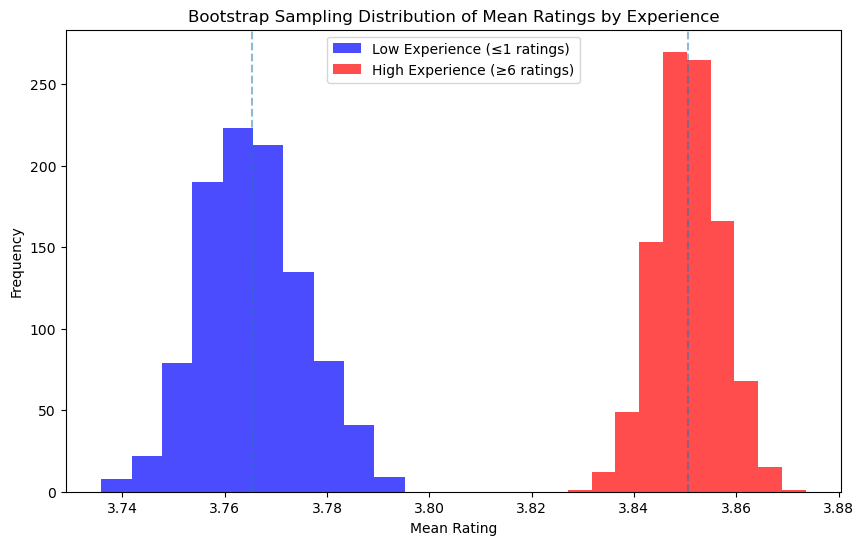

Bootstrap mean (low experience): 3.765
Bootstrap mean (high experience): 3.851


In [22]:
# bootstrapping means to visualize this difference 

low_exp_means = [low_exp.sample(frac=1, replace=True).mean() for _ in range(1000)]
high_exp_means = [high_exp.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.figure(figsize=(10, 6))
plt.hist(low_exp_means, alpha=0.7, label=f"Low Experience (≤{q1:.0f} ratings)", color="blue")
plt.hist(high_exp_means, alpha=0.7, label=f"High Experience (≥{q4:.0f} ratings)", color="red")

plt.xlabel("Mean Rating")
plt.ylabel("Frequency")
plt.title("Bootstrap Sampling Distribution of Mean Ratings by Experience")
plt.legend()

plt.axvline(np.mean(low_exp_means), linestyle="--", alpha=0.5)
plt.axvline(np.mean(high_exp_means), linestyle="--", alpha=0.5)

plt.show()

print(f"Bootstrap mean (low experience): {np.mean(low_exp_means):.3f}")
print(f"Bootstrap mean (high experience): {np.mean(high_exp_means):.3f}")

In [23]:
# again we see no overlap between distributions, can check cohen's d for practical sig

mean_diff = high_exp.mean() - low_exp.mean()
pooled_std = np.sqrt((np.std(low_exp)**2 + np.std(high_exp)**2) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.0738142977675147


## Question 3

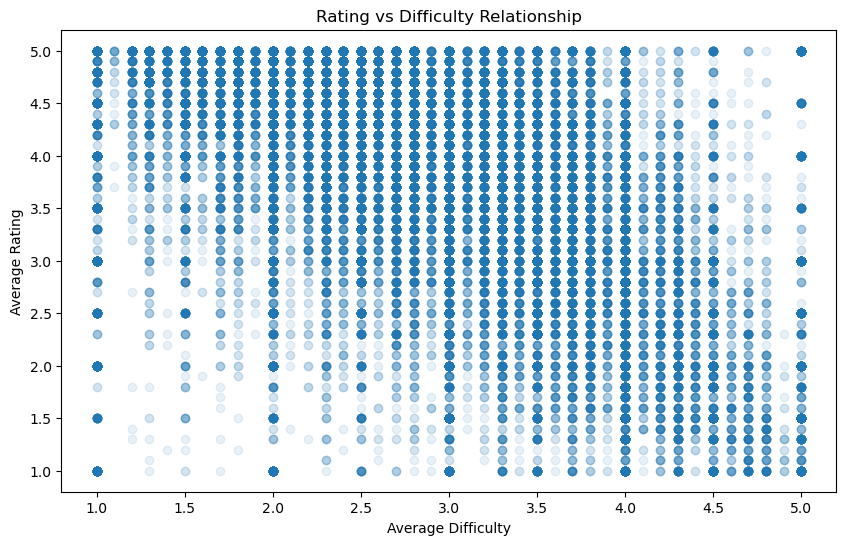

In [24]:
# will use un-adjusted avg rating here because we are dealing with 
# un-adjusted difficulty. we are not considering length of experience for either of them

# first visualizing relationship to pick best method of correlation
corr_df = rmpQuant[["avg_rating", "avg_diff"]].dropna()

plt.figure(figsize=(10, 6))
plt.scatter(corr_df["avg_diff"], corr_df["avg_rating"], alpha=0.1)
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title("Rating vs Difficulty Relationship")
plt.show()

In [25]:
# linear and decreasing, will use pearson's coefficient 
pearson_r, pearson_p = stats.pearsonr(corr_df["avg_diff"], corr_df["avg_rating"])
print(f"Pearson r: {pearson_r:.3f}")

Pearson r: -0.537


## Question 4

In [26]:
# first want to construct an online percentage column
rmpQuant["online_percentage"] = rmpQuant["num_online_ratings"] / rmpQuant["num_ratings"]

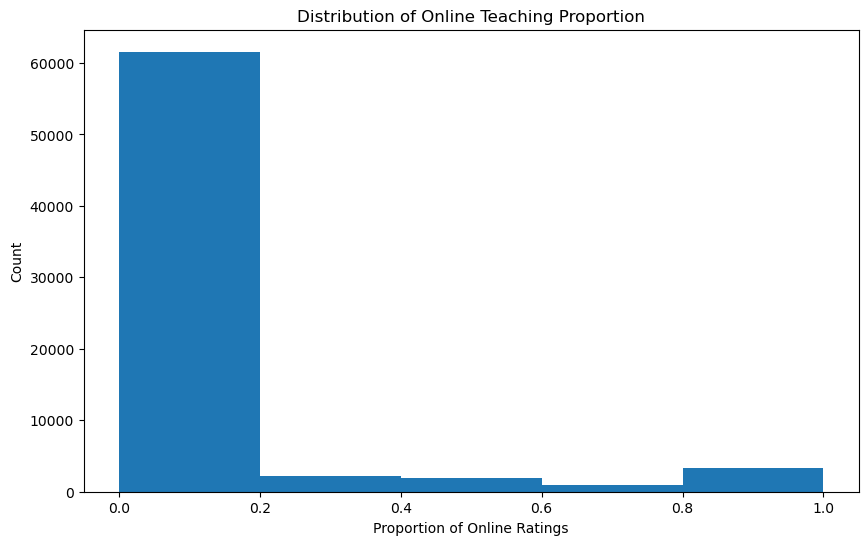

In [27]:
# want to visualize how online proportions are distributed
online_proportions = rmpQuant["online_percentage"].dropna()

plt.figure(figsize=(10, 6))
plt.hist(online_proportions, bins=5)  # more bins for better resolution
plt.title("Distribution of Online Teaching Proportion")
plt.xlabel("Proportion of Online Ratings")
plt.ylabel("Count")
plt.show()

In [28]:
# we see 2 distinct groups (though of uneqal sizing) < 0.2 and > 0.8
# cut the data into these two groups and then re-scale their sizes

# to control for covid (online) recency, i'm looking at cases where number of ratings is 2 for both

online_heavy = rmpQuant["avg_rating"][(rmpQuant["online_percentage"] > 0.8) & (rmpQuant["num_ratings"] == 2)].dropna()
inperson_heavy = rmpQuant["avg_rating"][(rmpQuant["online_percentage"] < 0.2) & (rmpQuant["num_ratings"] == 2)].dropna()

print(f"Number of online heavy classes: {online_heavy.shape[0]}")
print(f"Number of in-person heavy classes: {inperson_heavy.shape[0]}")

Number of online heavy classes: 645
Number of in-person heavy classes: 10170


In [29]:
online_sample = online_heavy.sample(n=645, random_state=seed)  
inperson_sample = inperson_heavy.sample(n=645, random_state=seed)

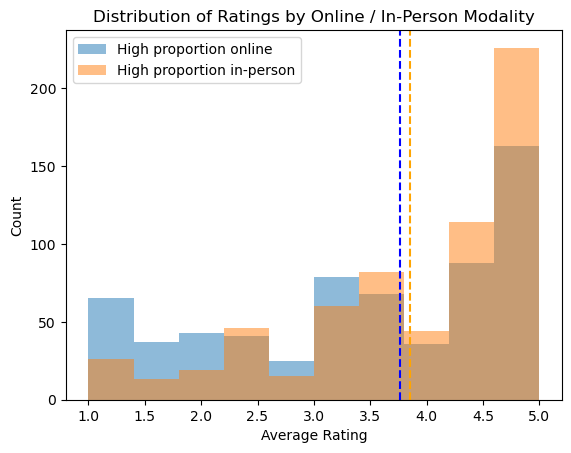

Mean rating (mostly online): 3.430
Mean rating (mostly in-person): 3.905


In [30]:
plt.hist(online_sample, bins=10, alpha=0.5, label="High proportion online")
plt.hist(inperson_sample, bins=10, alpha=0.5, label="High proportion in-person")

plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings by Online / In-Person Modality")
plt.legend()

plt.axvline(low_exp.mean(), color="blue", linestyle="--")
plt.axvline(high_exp.mean(), color="orange", linestyle="--")
plt.show()

print(f"Mean rating (mostly online): {online_sample.mean():.3f}")
print(f"Mean rating (mostly in-person): {inperson_sample.mean():.3f}")

In [31]:
# not distributed normally, going with mann-whitney u test

statistic, p_value = mannwhitneyu(online_sample, inperson_sample)
print(f"Mann-Whitney p-value: {round(p_value, 6)}")

Mann-Whitney p-value: 0.0


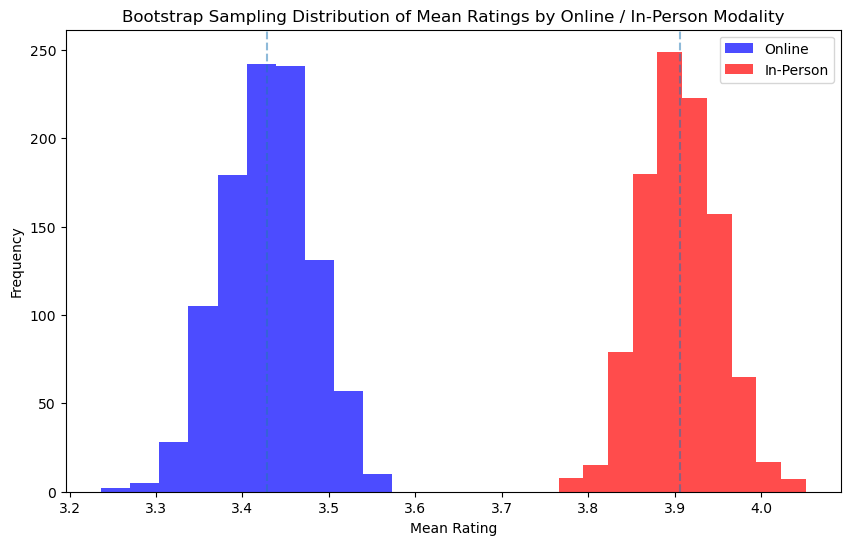

In [32]:
# bootstrapping means to visualize this difference 

online_means = [online_sample.sample(frac=1, replace=True).mean() for _ in range(1000)]
inperson_means = [inperson_sample.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.figure(figsize=(10, 6))
plt.hist(online_means, alpha=0.7, label="Online", color="blue")
plt.hist(inperson_means, alpha=0.7, label="In-Person", color="red")

plt.xlabel("Mean Rating")
plt.ylabel("Frequency")
plt.title("Bootstrap Sampling Distribution of Mean Ratings by Online / In-Person Modality")
plt.legend()

plt.axvline(np.mean(online_means), linestyle="--", alpha=0.5)
plt.axvline(np.mean(inperson_means), linestyle="--", alpha=0.5)

plt.show()

In [34]:
# effect size

mean_diff = inperson_sample.mean() - online_sample.mean()
pooled_std = np.sqrt((np.std(online_sample)**2 + np.std(inperson_sample)**2) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.3872063805719172


## Question 5

In [35]:
# want to filter out cases < 3 ratings for a more robust proportion analysis 
corr_df = rmpQuant[rmpQuant["avg_rating"] > 3][["avg_rating", "proportion_retake"]].dropna()

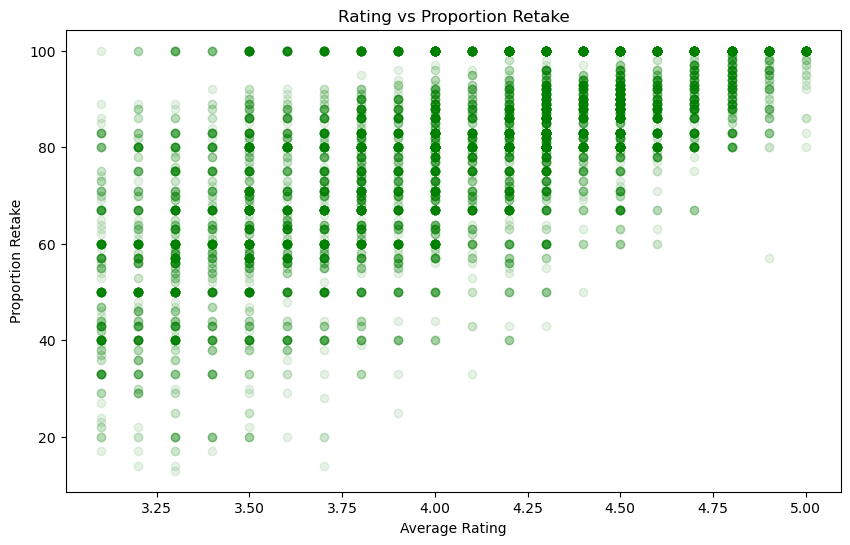

In [36]:
# visualizing relationship

plt.figure(figsize=(10, 6))
plt.scatter(corr_df["avg_rating"],corr_df["proportion_retake"], color="green", alpha=0.1)
plt.ylabel("Proportion Retake")
plt.xlabel("Average Rating")
plt.title("Rating vs Proportion Retake")
plt.show() 

In [37]:
# looks relatively linear and increasing, will use pearson

pearson_r, pearson_p = stats.pearsonr(corr_df["proportion_retake"], corr_df["avg_rating"])
print(f"Pearson r: {pearson_r:.3f}")

Pearson r: 0.767


## Question 6

In [102]:
# want to use adjusted rating here, weighting ratings by experience 
pepper_df = rmpQuant[["pepper", "log_rating"]].dropna()

hot = pepper_df[pepper_df["pepper"] == 1]
cold = pepper_df[pepper_df["pepper"] == 0]

num_hot = hot.shape[0]
num_cold = cold.shape[0]
print(f"Number of ratings for hot: {num_hot}")
print(f"Number of ratings for normal: {num_cold}")

Number of ratings for hot: 19596
Number of ratings for normal: 50408


In [103]:
# sizes are too different, need to downsample
sample_size = min(num_hot, num_cold)
random_hot_sample = hot["log_rating"].sample(sample_size, random_state=seed)
random_cold_sample = cold["log_rating"].sample(sample_size, random_state=seed)

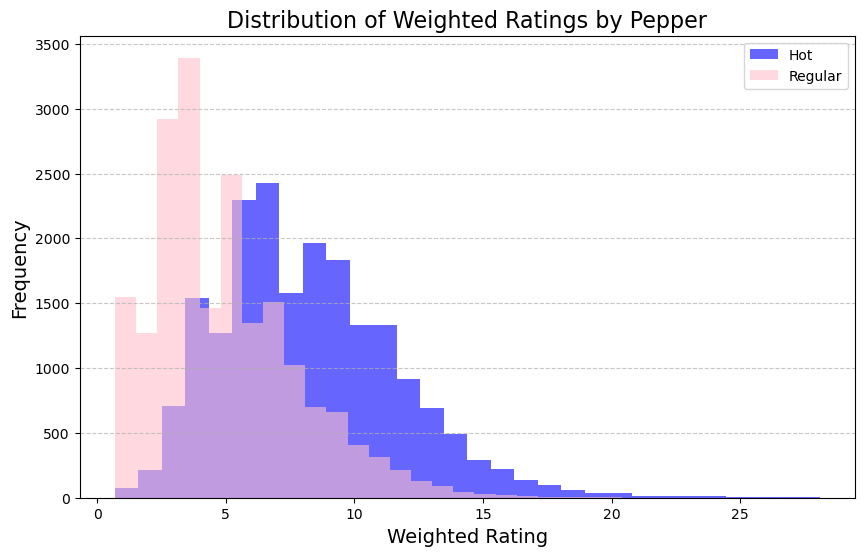

In [104]:
# first we check distributions of ratings to best pick test 
plt.figure(figsize=(10, 6))

plt.hist(random_hot_sample, bins=30, alpha=0.6, color="blue", label="Hot")
plt.hist(random_cold_sample, bins=30, alpha=0.6, color="pink", label="Regular")

plt.title("Distribution of Weighted Ratings by Pepper", fontsize=16)
plt.xlabel("Weighted Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [105]:
# by visual inspection these distributions look fairly normal, will use t-test

statistic, p_value = mannwhitneyu(random_hot_sample, random_cold_sample)
print(f"Mann-Whitney p-value: {round(p_value, 6)}")

Mann-Whitney p-value: 0.0


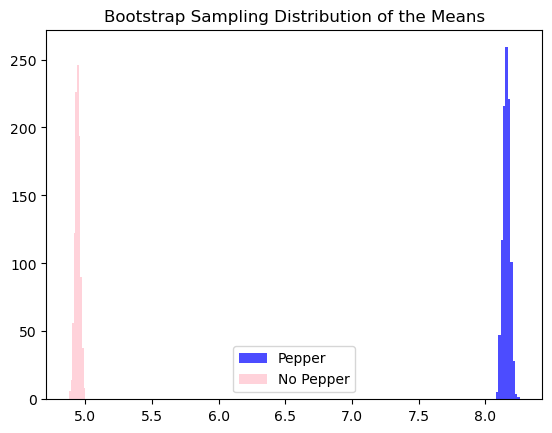

In [106]:
# bootstrapping to visualize this difference

hot_means = [random_hot_sample.sample(frac=1, replace=True).mean() for _ in range(1000)]
cold_means = [random_cold_sample.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.hist(hot_means, alpha=0.7, label="Pepper", color="blue")
plt.hist(cold_means, alpha=0.7, label="No Pepper", color="pink")
plt.legend()
plt.title("Bootstrap Sampling Distribution of the Means")
plt.show()

In [107]:
# checking cohen's d

mean_diff = random_hot_sample.mean() - random_cold_sample.mean()
pooled_std = np.sqrt((np.std(random_hot_sample)**2 + np.std(random_cold_sample)**2) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 1.0159417565687259


## Question 7

In [195]:
# since we are training model to predict average rating we will keep it in its raw form

X = rmpQuant["avg_diff"].dropna().values.reshape(-1, 1)
y = rmpQuant["avg_rating"].dropna().values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test set R² score: {r2:.4f}")
print(f"Test set RMSE: {rmse:.4f}")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

Test set R² score: 0.2903
Test set RMSE: 0.9517
Coefficient (slope): -0.6098
Intercept: 5.5559


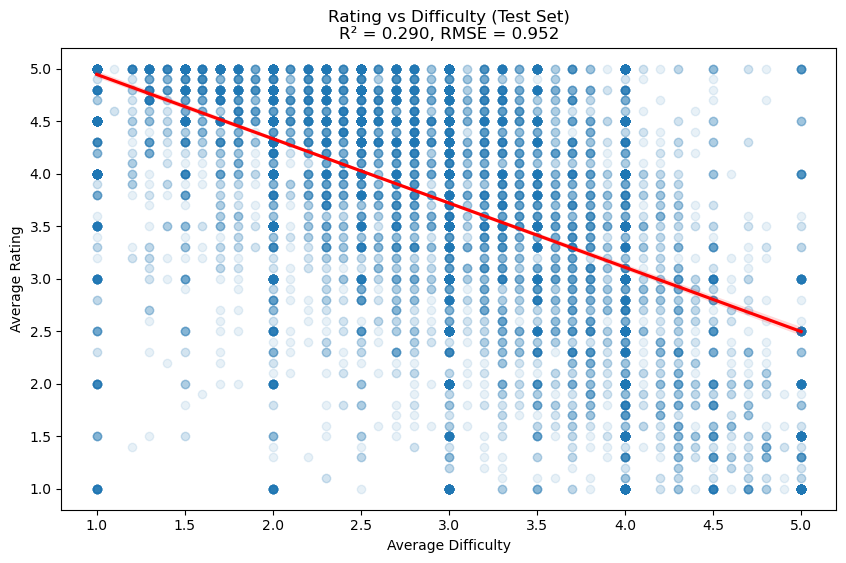

In [196]:
plt.figure(figsize=(10, 6))
sns.regplot(x=X_test.ravel(), y=y_test, 
            scatter_kws={"alpha":0.1},
            line_kws={"color": "red"})
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title(f"Rating vs Difficulty (Test Set)\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.show()

## Question 8

In [197]:
# approach: dimension reduction (where possible) and categorical encoding (where needed)
# again, want to use raw average rating here because that is what we are trying to predict

# get df back to original state
col_to_keep = ["avg_rating", "avg_diff", "num_ratings", "pepper", "proportion_retake", "num_online_ratings", "male", "female", "major", "stem", "region"]

merged_df = pd.concat([rmpQual, rmpQuant], axis=1)

# dropping all na here because now we want only full rows
merged_df = merged_df[col_to_keep].dropna() 

In [198]:
# separate target variable
y = merged_df["avg_rating"]

# PCA for rest of quantitative data
numeric_cols = ["avg_diff", "num_ratings", "proportion_retake", "num_online_ratings"]

X = merged_df[numeric_cols]
zscoredData = stats.zscore(X)
pca = PCA().fit(zscoredData)
eigVals = pca.explained_variance_
loadings = pca.components_
rotatedData = pca.fit_transform(zscoredData)
varExplained = eigVals/sum(eigVals)*100

print("Cumulative explained variance:")
cumulative = np.cumsum(varExplained)
for i, cum_var in enumerate(cumulative):
    print(f"Through PC{i+1}: {cum_var:.2f}%")

Cumulative explained variance:
Through PC1: 38.27%
Through PC2: 65.71%
Through PC3: 88.34%
Through PC4: 100.00%


In [199]:
# dimension reduction
pca = PCA(n_components=3) 
rotatedData = pca.fit_transform(zscoredData) 
loadings = pca.components_ 

loading_df = pd.DataFrame(
    loadings.T,  # transpose to get variables as rows
    columns=["PC1", "PC2", "PC3"],
    index=numeric_cols
)

print(loading_df)

pca_df = pd.DataFrame(
    rotatedData,  
    columns=["PC1", "PC2", "PC3"]
)

                         PC1       PC2       PC3
avg_diff            0.705982  0.050834  0.056134
num_ratings        -0.028658  0.710227  0.699022
proportion_retake  -0.706239 -0.022378  0.072592
num_online_ratings -0.044656  0.701779 -0.709188


In [200]:
# handling binary columns 
binary_cols = ["pepper", "male", "stem"]  
X_binary = merged_df[binary_cols]

In [201]:
# handle qualitative data
X_region = pd.get_dummies(merged_df.loc[X.index, "region"])

In [202]:
# re-combine all features

X_combined = pd.concat([
    pca_df.reset_index(drop=True),
    X_binary.reset_index(drop=True),
    X_region.reset_index(drop=True)
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=seed)

# regression
model = LinearRegression()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test set R² score: {r2:.4f}")
print(f"Test set RMSE: {rmse:.4f}")

Test set R² score: 0.7614
Test set RMSE: 0.4214


Text(0.5, 1.0, 'Actual vs Predicted Ratings')

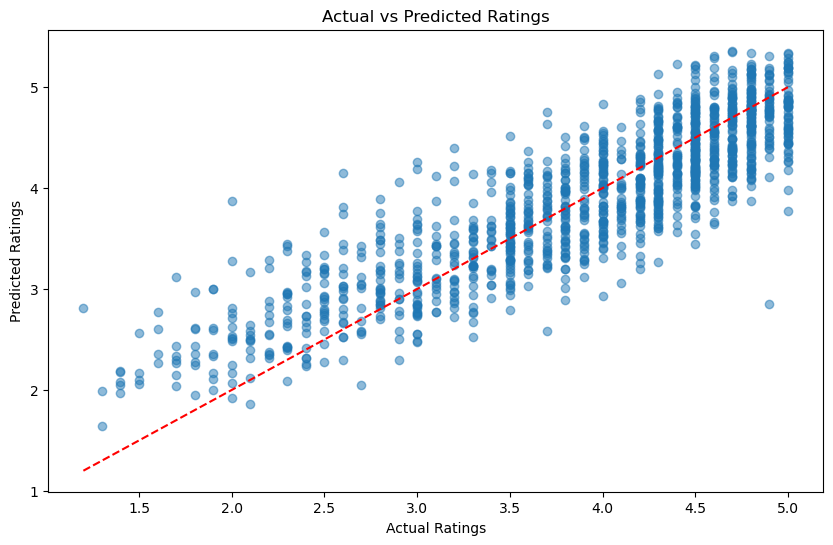

In [203]:
# visualizing relationship between actual and predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--") # reference line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")

## Question 9

In [204]:
pepperRating = rmpQuant[["avg_rating", "pepper"]].dropna()
pepper_counts = pepperRating["pepper"].value_counts()

# want to see size of each category
print(pepper_counts)

# not equal, will take a sample size of 19500 of each
pepper = pepperRating[pepperRating["pepper"] == 1]
no_pepper = pepperRating[pepperRating["pepper"] == 0]

pepper_sample = pepper.sample(n=19500, random_state=seed)
no_pepper_sample = no_pepper.sample(n=19500, random_state=seed)
pepperRating = pd.concat([pepper_sample, no_pepper_sample])

pepper
0.0    50408
1.0    19596
Name: count, dtype: int64


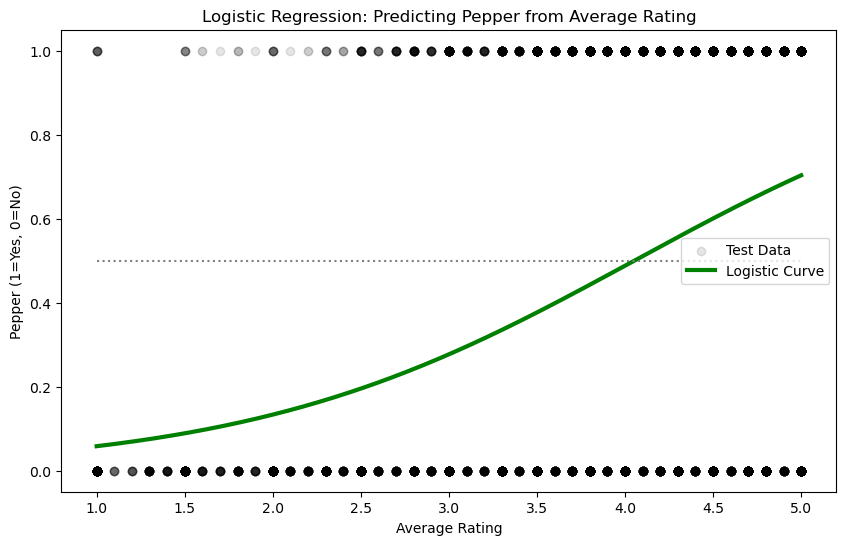

In [205]:
X = pepperRating["avg_rating"].values.reshape(-1, 1)  
y = pepperRating["pepper"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
model = LogisticRegression()
model.fit(X_train, y_train)

X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_plot = model.predict_proba(X_plot)[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", alpha=0.1, label="Test Data")
plt.plot(X_plot, y_plot, color="green", linewidth=3, label="Logistic Curve")
plt.hlines(0.5, X.min(), X.max(), colors="gray", linestyles="dotted")
plt.xlabel("Average Rating")
plt.ylabel("Pepper (1=Yes, 0=No)")
plt.title("Logistic Regression: Predicting Pepper from Average Rating")
plt.legend()

In [206]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auroc_single = roc_auc_score(y_test, y_pred_proba)
print(f"Test set AUROC: {auroc_single:.3f}")

Test set AUROC: 0.692


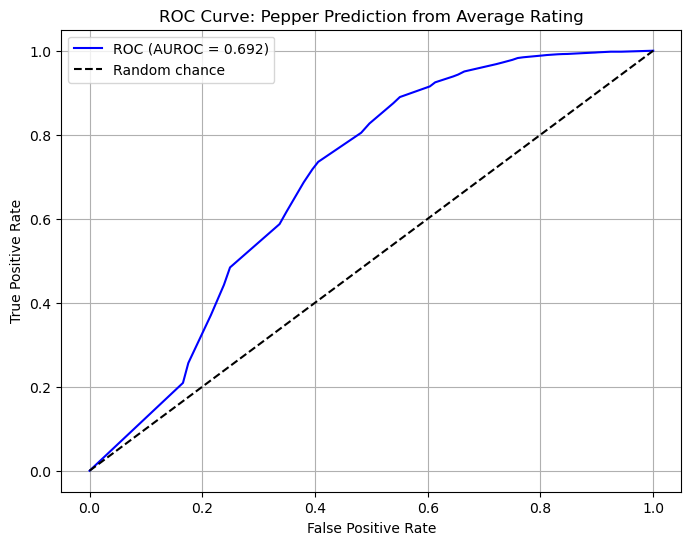

In [207]:
fpr_single, tpr_single, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_single, tpr_single, "b-", label=f"ROC (AUROC = {auroc_single:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Pepper Prediction from Average Rating")
plt.legend()
plt.grid(True)
plt.show()

## Question 10

In [208]:
# pca is slightly different from before, we are keeping all numeric columns this time

numeric_cols = ["avg_diff", "num_ratings", "proportion_retake", "num_online_ratings", "avg_rating"]
X = merged_df[numeric_cols]

zscoredData = stats.zscore(X)
pca = PCA().fit(zscoredData)
eigVals = pca.explained_variance_
loadings = pca.components_
rotatedData = pca.fit_transform(zscoredData)
varExplained = eigVals/sum(eigVals)*100

print("Cumulative explained variance:")
cumulative = np.cumsum(varExplained)
for i, cum_var in enumerate(cumulative):
    print(f"Through PC{i+1}: {cum_var:.2f}%")

Cumulative explained variance:
Through PC1: 47.07%
Through PC2: 69.02%
Through PC3: 87.14%
Through PC4: 97.68%
Through PC5: 100.00%


In [209]:
# again reducing to 3 components

pca = PCA(n_components=3) 
rotatedData = pca.fit_transform(zscoredData) 
loadings = pca.components_ 

loading_df = pd.DataFrame(
    loadings.T,  # transpose to get variables as rows
    columns=["PC1", "PC2", "PC3"],
    index=numeric_cols
)
print("\nLoadings:")
print(loading_df)

# Create DataFrame of transformed data (samples x components)
pca_df = pd.DataFrame(
    rotatedData,  # already has 3 components
    columns=["PC1", "PC2", "PC3"]
)


Loadings:
                         PC1       PC2       PC3
avg_diff            0.509022  0.031086  0.090180
num_ratings        -0.019079  0.709593  0.698622
proportion_retake  -0.600120 -0.007298  0.052629
num_online_ratings -0.018411  0.703814 -0.707466
avg_rating         -0.616482 -0.010207  0.022735


In [210]:
# don't want pepper, need it now to separate into categories but will drop later
binary_cols = ["pepper", "male", "stem"] 
X_binary = merged_df[binary_cols]

In [211]:
# handling qualitative the same as before
X_region = pd.get_dummies(merged_df.loc[X.index, "region"])

In [212]:
X_combined = pd.concat([
    pca_df.reset_index(drop=True),
    X_binary.reset_index(drop=True),
    X_region.reset_index(drop=True)
], axis=1)

In [213]:
pepper = X_combined[X_combined["pepper"] == 1]
no_pepper = X_combined[X_combined["pepper"] == 0]

print(pepper.shape)
print(no_pepper.shape)

# ensuring balanced sample sizes
pepper_sample = pepper.sample(n=3070, random_state=seed)
no_pepper_sample = no_pepper.sample(n=3070, random_state=seed)

X_combined = pd.concat([pepper_sample, no_pepper_sample])
y = X_combined["pepper"] # set target variable
X = X_combined.drop(columns="pepper") # drop target from X comined

(3079, 11)
(3626, 11)


In [214]:
# model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.3f}")

AUROC: 0.744


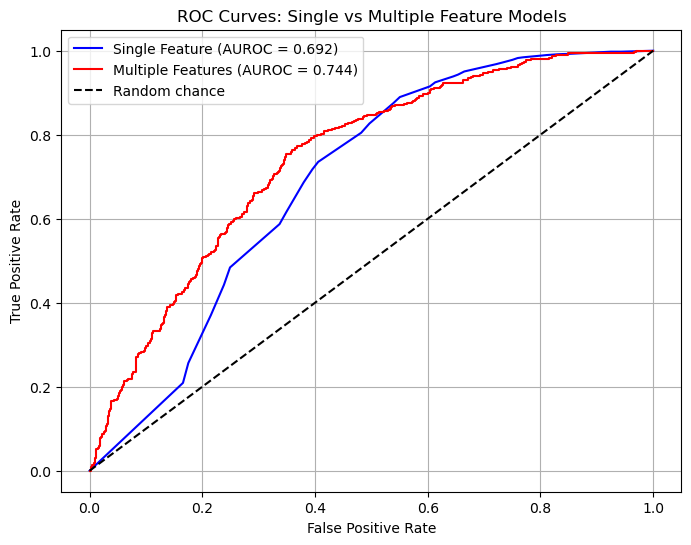

In [215]:
fpr_multi, tpr_multi, _ = roc_curve(y_test, y_pred_proba)

# plotting together 
plt.figure(figsize=(8, 6))
plt.plot(fpr_single, tpr_single, "b-", 
         label=f"Single Feature (AUROC = {auroc_single:.3f})")
plt.plot(fpr_multi, tpr_multi, "r-", 
         label=f"Multiple Features (AUROC = {auroc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Single vs Multiple Feature Models")
plt.legend()
plt.grid(True)
plt.show()

## EXTRA CREDIT

In [153]:
# is there a difference between how stem professors are rated versus humanities professors

merged_df = pd.concat([rmpQual, rmpQuant], axis=1)
stemRating = merged_df[["stem", "log_rating"]].dropna()

stem_ratings = stemRating[stemRating["stem"] == 1]["log_rating"]
hum_ratings = stemRating[stemRating["stem"] == 0]["log_rating"]

print("Sample sizes:")
print(f"STEM: {len(stem_ratings)}")
print(f"Humanities: {len(hum_ratings)}")

Sample sizes:
STEM: 17383
Humanities: 21022


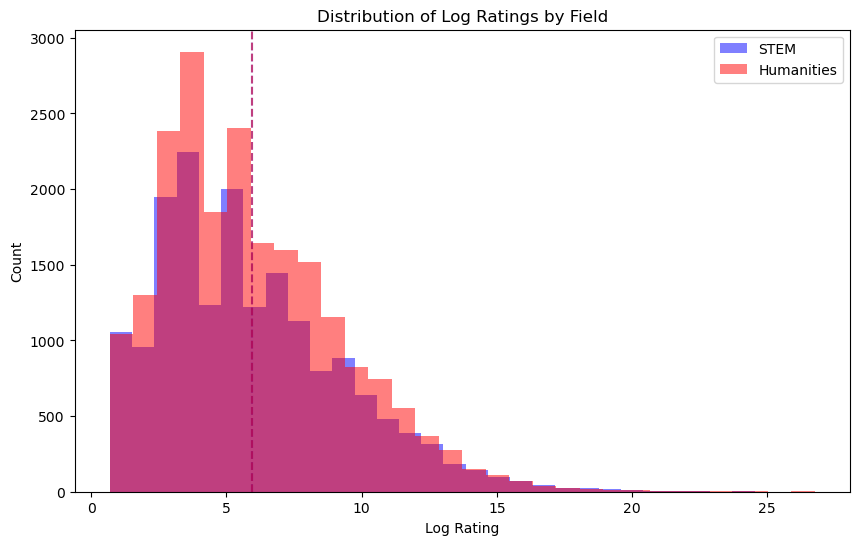

Mean STEM rating: 5.946
Mean Humanities rating: 5.953


In [154]:
plt.figure(figsize=(10, 6))

# visualizing 
plt.hist(stem_ratings, bins=30, alpha=0.5, label="STEM", color="blue")
plt.hist(hum_ratings, bins=30, alpha=0.5, label="Humanities", color="red")

plt.xlabel("Log Rating")
plt.ylabel("Count")
plt.title("Distribution of Log Ratings by Field")
plt.legend()

# mean lines
plt.axvline(stem_ratings.mean(), color="blue", linestyle="--", alpha=0.5)
plt.axvline(hum_ratings.mean(), color="red", linestyle="--", alpha=0.5)

plt.show()

print(f"Mean STEM rating: {stem_ratings.mean():.3f}")
print(f"Mean Humanities rating: {hum_ratings.mean():.3f}")

In [155]:
# significance test
stat, pval = stats.mannwhitneyu(stem_ratings, hum_ratings)
print(f"\nP-value: {pval:.4f}")


P-value: 0.0956


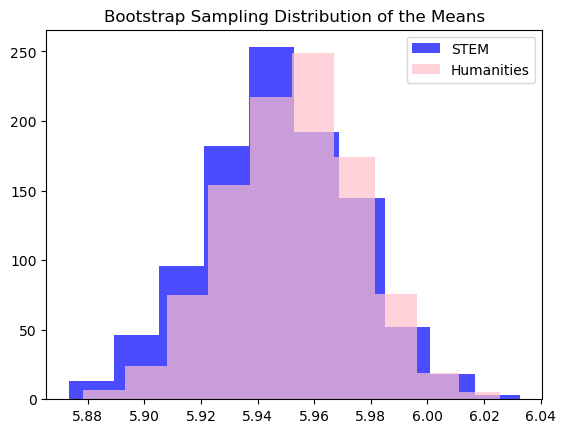

In [156]:
stem_means = [stem_ratings.sample(frac=1, replace=True).mean() for _ in range(1000)]
hum_means = [hum_ratings.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.hist(stem_means, alpha=0.7, label="STEM", color="blue")
plt.hist(hum_means, alpha=0.7, label="Humanities", color="pink")
plt.legend()
plt.title("Bootstrap Sampling Distribution of the Means")
plt.show()

In [157]:
# running again, this time looking at stem vs difficulty

merged_df = pd.concat([rmpQual, rmpQuant], axis=1)
stemRating = merged_df[["stem", "avg_diff"]].dropna()

stem_ratings = stemRating[stemRating["stem"] == 1]["avg_diff"]
hum_ratings = stemRating[stemRating["stem"] == 0]["avg_diff"]

print("Sample sizes:")
print(f"STEM: {len(stem_ratings)}")
print(f"Humanities: {len(hum_ratings)}")

Sample sizes:
STEM: 17383
Humanities: 21022


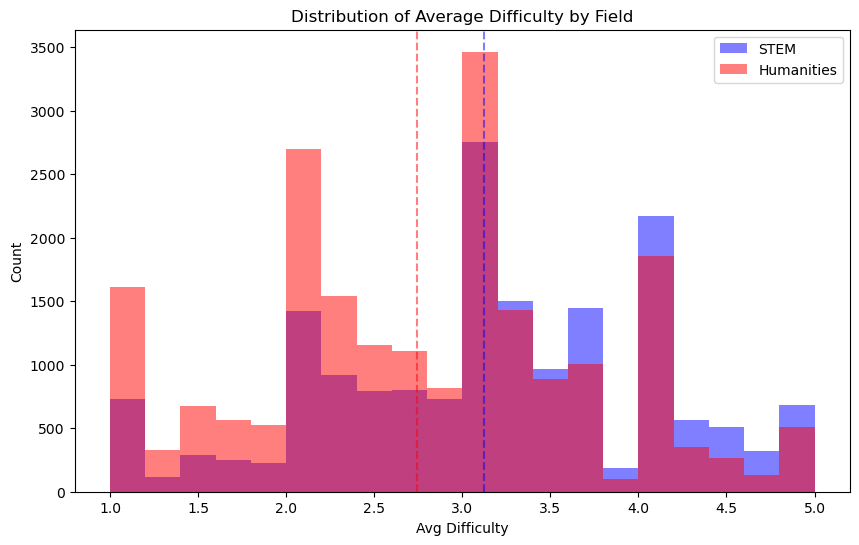

Mean STEM rating: 3.125
Mean Humanities rating: 2.743


In [158]:
plt.figure(figsize=(10, 6))

# visualizing 
plt.hist(stem_ratings, bins=20, alpha=0.5, label="STEM", color="blue")
plt.hist(hum_ratings, bins=20, alpha=0.5, label="Humanities", color="red")

plt.xlabel("Avg Difficulty")
plt.ylabel("Count")
plt.title("Distribution of Average Difficulty by Field")
plt.legend()

# mean lines
plt.axvline(stem_ratings.mean(), color="blue", linestyle="--", alpha=0.5)
plt.axvline(hum_ratings.mean(), color="red", linestyle="--", alpha=0.5)

plt.show()

print(f"Mean STEM rating: {stem_ratings.mean():.3f}")
print(f"Mean Humanities rating: {hum_ratings.mean():.3f}")

In [159]:
# significance test
stat, pval = stats.mannwhitneyu(stem_ratings, hum_ratings)
print(f"\nP-value: {pval:.4f}")


P-value: 0.0000


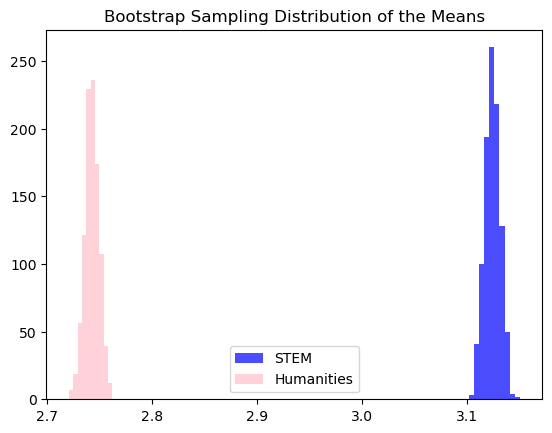

In [160]:
stem_means = [stem_ratings.sample(frac=1, replace=True).mean() for _ in range(1000)]
hum_means = [hum_ratings.sample(frac=1, replace=True).mean() for _ in range(1000)]

plt.hist(stem_means, alpha=0.7, label="STEM", color="blue")
plt.hist(hum_means, alpha=0.7, label="Humanities", color="pink")
plt.legend()
plt.title("Bootstrap Sampling Distribution of the Means")
plt.show()